In [1]:
%matplotlib inline

import os
import sys
import glob
import h5py
import queue
import itertools
import multiprocessing

from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from typing import Iterator

from sklearn.cluster import AgglomerativeClustering, DBSCAN

from falcon_ext.ms_io import mzml_io
from falcon_ext.cluster import similarity, masking, clustering
from falcon_ext.preprocessing import preprocessing
from falcon_ext.plot import network

from falcon_ext import config
from falcon_ext.config import *

from spectrum_utils.spectrum import MsmsSpectrum
from spectrum_utils import *

In [2]:
input_files = glob.glob("../data/mouse_data/*/*.mzML")
print(len(input_files))

annotations_file = "../data/mouse_data/annotations.tsv"

spectrum_db_file = "../data/mouse_data/spectrum_db.hdf5"

config.parse([input_files, annotations_file])

48


In [3]:
# count spectra in dataset
spectrum_count = 0
masses = []
for file in input_files: 
    spectra = list(mzml_io.get_spectra(source=file))
    masses += [s.precursor_mz for s in spectra]
    spectrum_count += len(spectra)
print(spectrum_count)

263729


In [4]:
print(len(masses))
print(len(set(masses)))

263729
263628


In [3]:
def create_dataset(input_files, output_file):

    # Open the output HDF5 file
    with h5py.File(output_file, 'w') as hdf_file:

        # Iterate over each MGF file in the input folder
        for filename in tqdm(glob.glob(input_files)):
                
            raw_spectra = mzml_io.get_spectra(source=filename)
            spectra = list(preprocessing.process_all_spectra(raw_spectra, 
                                                    config.min_peaks, config.min_mz_range,
                                                    config.min_mz, config.max_mz,
                                                    config.remove_precursor_tol,
                                                    config.min_intensity, 
                                                    config.max_peaks_used, config.scaling))

            # Iterate over each spectrum in the MGF file
            for spectrum in spectra:

                if spectrum is None:
                    continue
                
                # Access relevant information (m/z, intensity and precursor mass)
                mz_data = spectrum.mz
                intensity_data = spectrum.intensity
                precursor_mass = spectrum.precursor_mz

                group_name = str(precursor_mass)

                # Create a group if it doesn't exist
                if group_name not in hdf_file:
                    group = hdf_file.create_group(group_name)
                else:
                    group = hdf_file[group_name]

                # Store the spectrum data in the group
                basename = os.path.splitext(os.path.basename(filename))[0]
                spectrum_dataset_name = f'spectrum_{spectrum.identifier}_{basename}'
                # spectrum_group = group.create_group(spectrum_dataset_name)
                try: 
                    spectrum_group = group.create_group(spectrum_dataset_name)
                except ValueError:
                    print(f'ValueError: {filename}, {spectrum_dataset_name}, {precursor_mass}')
                    continue
                spectrum_group.create_dataset('mz', data=mz_data)
                spectrum_group.create_dataset('intensity', data=intensity_data)
                

In [6]:
create_dataset("../data/mouse_data/*/*.mzML", spectrum_db_file)

100%|██████████| 48/48 [14:00<00:00, 17.52s/it]


In [6]:
with h5py.File("../data/mouse_data/spectrum_db.hdf5", 'r') as hdf_file:
    # print(list(hdf_file.keys()))

    pepmasses = [float(pm) for pm in list(hdf_file.keys())]
    # # Get the group corresponding to the precursor mass 1000.0
    # group = hdf_file['1000.0']

    # # Get the spectrum corresponding to the identifier 0
    # spectrum = group['spectrum_0']

    # # Get the m/z and intensity data
    # mz_data = spectrum['mz']
    # intensity_data = spectrum['intensity']

    # # Plot the spectrum
    # plt.plot(mz_data, intensity_data)
    # plt.show()
    print(pepmasses[0])
    print(len(pepmasses))

100.50976826
263628


In [17]:
def cluster_precursor_masses(precursor_masses, precursor_mz_tol):
    """Cluster precursor masses by a given tolerance.
       Single linkage hierarchical clustering is used.
    
    Parameters:
    -----------
    precursor_masses: list
        List of precursor masses.
    precursor_mz_tol: float
        Mass tolerance for clustering.
        
    Returns:
    --------
    cluster_lables: list
        List of cluster labels.
    """
    # clustering = AgglomerativeClustering(n_clusters=None, 
    #                                      metric='euclidean',
    #                                      distance_threshold=precursor_mz_tol, 
    #                                      linkage='average').fit(np.asarray(precursor_masses).reshape(-1, 1))
    clustering = DBSCAN(eps=precursor_mz_tol, min_samples=1).fit(np.asarray(precursor_masses).reshape(-1, 1))

    return clustering.labels_


def create_cluster_dict(cluster_labels, precursor_masses):
    """Create a dictionary of cluster labels and the corresponding precursor masses.
    
    Parameters:
    -----------
    cluster_labels: list
        List of cluster labels.
        
    Returns:
    --------
    cluster_dict: dict
        Dictionary of cluster labels and the corresponding precursor masses.
    """
    cluster_dict = {}
    for cluster_label, precursor_mass in zip(cluster_labels, precursor_masses):
        if cluster_label not in cluster_dict:
            cluster_dict[cluster_label] = []
        cluster_dict[cluster_label].append(precursor_mass)
    return cluster_dict


def bin_spectra_by_precursor_mass(spectrum_db_file, precursor_mz_tol):

    with h5py.File(spectrum_db_file, 'r') as spectrum_db:
        pepmasses = [float(pm) for pm in list(spectrum_db.keys())]

    # Cluster precursor masses
    cluster_labels = cluster_precursor_masses(pepmasses, precursor_mz_tol)
    # Create a dictionary of cluster labels and the corresponding precursor masses
    print('create cluster dict')
    cluster_dict = create_cluster_dict(cluster_labels, pepmasses)

    return cluster_dict

In [18]:
pepmass_cluster_dict = bin_spectra_by_precursor_mass(spectrum_db_file, 0.05)

print('number of clusters:', len(pepmass_cluster_dict))
print('maximal cluster size:', max([len(v) for v in pepmass_cluster_dict.values()]))

: 

In [9]:
with h5py.File(spectrum_db_file, 'r') as spectrum_db:
    
    for cluster in tqdm(pepmass_cluster_dict.keys()):
        
        # get all raw spectra for a cluster
        raw_spectra = []
        for precursor_mz in pepmass_cluster_dict[cluster]:
            group = spectrum_db[str(precursor_mz)]
            for spectrum in group.values():  
                raw_spectra.append((spectrum.name, precursor_mz, spectrum))

        # convert raw spectra to MsmsSpectrum objects and sort by precursor mass
        spectra = []
        for spectrum in raw_spectra:
            spectra.append(MsmsSpectrum(identifier= spectrum[0], precursor_mz=spectrum[1], precursor_charge=1, 
                                        mz=np.asarray(spectrum[2]['mz']), intensity=np.asarray(spectrum[2]['intensity'])))
        spectra.sort(key=lambda x: x.precursor_mz)
        
        # compute distance matrix for each cluster
        if len(spectra) > 1:
            # similarity_matrix, matches_matrix = similarity.create_mod_cos_similarity_matrix(spectra, config.fragment_tol)
            try:
                similarity_matrix, matches_matrix = similarity.create_mod_cos_similarity_matrix(spectra, config.fragment_tol)
            except ZeroDivisionError as e:
                print([len(s.mz) for s in spectra])
                print(e)
                continue
            distance_matrix = similarity.similarity_to_distance(similarity_matrix)
        else: 
            distance_matrix = np.asarray([0])

        # save distance matrix to file, overwrite if exists
        folder_path = f'../data/mouse_data/distance_matrices'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        distance_matrix_file = f'{folder_path}/distance_matrix_{cluster}'
        similarity.save_matrix(distance_matrix, distance_matrix_file)


 22%|██▏       | 852/3910 [1:24:47<3:11:51,  3.76s/it]   

: 

In [6]:
def read_spectra_from_db(spectrum_db_file, cluster):
    
    with h5py.File(spectrum_db_file, 'r') as spectrum_db:
        
        # get all raw spectra for the cluster
        raw_spectra = []
        for precursor_mz in pepmass_cluster_dict[cluster]:
            group = spectrum_db[str(precursor_mz)]
            for spectrum in group.values():  
                raw_spectra.append((spectrum.name, precursor_mz, spectrum))

        # convert raw spectra to MsmsSpectrum objects and sort by precursor mass
        spectra = []
        for spectrum in raw_spectra:
            spectra.append(MsmsSpectrum(identifier= spectrum[0], precursor_mz=spectrum[1], precursor_charge=1, 
                                        mz=np.asarray(spectrum[2]['mz']), intensity=np.asarray(spectrum[2]['intensity'])))
        spectra.sort(key=lambda x: x.precursor_mz)

        return spectra

In [7]:
dist_matrix_files = glob.glob("../data/mouse_data/distance_matrices/*.npz")
dist_matrix_files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[2].split('.')[0]))

clustered_spectra_file = f'../data/mouse_data/clustered_spectra.hdf5'
if os.path.isfile(clustered_spectra_file):
    os.remove(clustered_spectra_file)

spectrum_count = 0

# cluster spectra in each distance matrix
for file in dist_matrix_files:

    # get cluster id from file name
    cluster = int(os.path.splitext(os.path.basename(file))[0].split('_')[2].split('.')[0])

    # read spectra from database
    spectra = read_spectra_from_db(spectrum_db_file, cluster)
    spectrum_count += len(spectra)

    if len(spectra) < 2:

        with h5py.File(clustered_spectra_file, 'a') as hdf_file:
            spectrum = spectra[0]
            group_name = str(spectrum.identifier)
            
            if group_name not in hdf_file:
                group = hdf_file.create_group(group_name)
            else:
                group = hdf_file[group_name]
                
            group.create_dataset('pepmass', data=spectrum.precursor_mz)
            group.create_dataset('charge', data=spectrum.precursor_charge)
            group.create_dataset('mz', data=spectrum.mz)
            group.create_dataset('intensity', data=spectrum.intensity)
        continue

    distance_matrix = similarity.load_matrix(file)
    similarity_matrix = similarity.similarity_to_distance(distance_matrix)

    mask = masking.generate_mask(spectra, config.precursor_tol)
    masked_distance_matrix = similarity.similarity_to_distance(np.multiply(similarity_matrix, mask))
    masked_distance_matrix = np.where(masked_distance_matrix>0, masked_distance_matrix, 0)

    print(f'{cluster}: cluster {len(spectra)} spectra')
    cluster = clustering.generate_clusters(masked_distance_matrix, config.cluster_method, 
                                           config.linkage, config.eps, config.min_cluster_size)

    spectra_to_save = np.concatenate((cluster.cluster_samples, cluster.noise_samples))
    # print(len(cluster.cluster_samples))
    # print(len(cluster.noise_samples))
    print(f'spectrum reduction: {1 - len(spectra_to_save)/len(spectra)}')

    # write medoids and noise to hdf file
    with h5py.File(clustered_spectra_file, 'a') as hdf_file:
        
        for spec_idx in spectra_to_save:
            
            spectrum = spectra[spec_idx]
            group_name = str(spectrum.identifier).split('/')[-1]
            
            if group_name not in hdf_file:
                group = hdf_file.create_group(group_name)
            else:
                group = hdf_file[group_name]
                
            group.create_dataset('pepmass', data=spectrum.precursor_mz)
            group.create_dataset('charge', data=spectrum.precursor_charge)
            group.create_dataset('mz', data=spectrum.mz)
            group.create_dataset('intensity', data=spectrum.intensity)
    
    # eval.evaluate_clustering(annotations_file, cluster, scan_idx_list)

print(spectrum_count)

2: cluster 2 spectra
spectrum reduction: 0.0
3: cluster 131 spectra
spectrum reduction: 0.9465648854961832
6: cluster 15 spectra
spectrum reduction: 0.7333333333333334
7: cluster 75 spectra
spectrum reduction: 0.9333333333333333
9: cluster 58 spectra
spectrum reduction: 0.5689655172413793
10: cluster 3 spectra
spectrum reduction: 0.6666666666666667
11: cluster 192 spectra
spectrum reduction: 0.0
13: cluster 68 spectra
spectrum reduction: 0.9411764705882353
16: cluster 4 spectra
spectrum reduction: 0.0
17: cluster 88 spectra
spectrum reduction: 0.9886363636363636
18: cluster 14 spectra
spectrum reduction: 0.0
19: cluster 36 spectra
spectrum reduction: 0.8888888888888888
20: cluster 21 spectra
spectrum reduction: 0.0
21: cluster 4 spectra
spectrum reduction: 0.0
23: cluster 4 spectra
spectrum reduction: 0.0
24: cluster 131 spectra
spectrum reduction: 0.9236641221374046
25: cluster 2 spectra
spectrum reduction: 0.0
27: cluster 7 spectra
spectrum reduction: 0.0
28: cluster 15 spectra
spect

In [11]:
cluster = 851

spectra = read_spectra_from_db(spectrum_db_file, cluster)
spectrum_count += len(spectra)

print([s.precursor_mz for s in spectra])

file = glob.glob(f'../data/mouse_data/distance_matrices/distance_matrix_{cluster}.npy.npz')[0]
distance_matrix = similarity.load_matrix(file)
similarity_matrix = similarity.similarity_to_distance(distance_matrix)

# mask = masking.generate_mask(spectra, config.precursor_tol)
# masked_distance_matrix = similarity.similarity_to_distance(np.multiply(similarity_matrix, mask))
# masked_distance_matrix = np.where(masked_distance_matrix>0, masked_distance_matrix, 0)

print(similarity_matrix)

cluster = clustering.generate_clusters(distance_matrix, config.cluster_method, 
                                       config.linkage, 0.5, config.min_cluster_size)

network.network_from_clusters(spectra, cluster.cluster_samples, cluster.noise_samples, 
                              distance_matrix, matches_matrix, config.max_edges, 
                              config.max_edge_dist, config.min_matched_peaks)
print(len(spectra), len(cluster.cluster_samples) + len(cluster.noise_samples))

[270.62201911, 270.62202067, 270.6227318, 270.62338431, 270.6234758, 270.62370108, 270.62380564, 270.62399744, 270.62466298, 270.62466468, 270.62494249, 270.64289296, 270.64420658, 270.64426203, 270.64440492, 270.64445101, 270.644601, 270.64484844, 270.6457135, 270.64612503, 270.64688768, 270.64692478, 270.64698692, 270.64736258, 270.64740672, 270.65847223, 270.65925716, 270.65958402, 270.65973008, 270.65989315, 270.65991541, 270.66004058, 270.66027112, 270.66037198, 270.66083321, 270.66093609]
[[1.         0.21333737 0.3221561  ... 0.05061083 0.02042711 0.07332573]
 [0.21333737 1.         0.43066972 ... 0.04765792 0.         0.08885306]
 [0.3221561  0.43066972 1.         ... 0.07482886 0.         0.17673797]
 ...
 [0.05061083 0.04765792 0.07482886 ... 1.         0.53546854 0.11434596]
 [0.02042711 0.         0.         ... 0.53546854 1.         0.11678654]
 [0.07332573 0.08885306 0.17673797 ... 0.11434596 0.11678654 1.        ]]


NameError: name 'matches_matrix' is not defined

In [12]:
import fnmatch

pattern = '270.62*'

with h5py.File(spectrum_db_file, 'r') as spectrum_db:
    matching_groups = [group_name for group_name in spectrum_db.keys() if fnmatch.fnmatch(group_name, pattern)]
    
    for group_name in matching_groups:
        group = spectrum_db[group_name]
        for spectrum in group.values():
            print(spectrum.name)

/270.62201911/spectrum_2777_SPF2_Duo3_GC6_01_22121
/270.62202067/spectrum_2795_SPF3_Duo5_GC8_01_22349
/270.6227318/spectrum_2782_GF4_Duo6_BC9_01_22463
/270.62338431/spectrum_2794_GF4_Duo6_BC9_01_22463
/270.6234758/spectrum_2776_SPF3_Duo1_GC4_01_22345
/270.62370108/spectrum_2798_GF1_Duo2_GC5_01_21762
/270.62380564/spectrum_2732_SPF4_Duo5_GC8_01_22575
/270.62399744/spectrum_2720_GF2_Duo5_BC8_01_22010
/270.62466298/spectrum_2731_GF2_Duo3_BC6_01_22008
/270.62466468/spectrum_2809_SPF3_Duo5_GC8_01_22349
/270.62494249/spectrum_2742_SPF4_Duo6_GC9_01_22576


In [3]:
spectra = list(mzml_io.get_spectra(source='../data/mouse_data/SPF2/SPF2_Duo3_GC6_01_22121.mzML'))
spec1 = [spec for spec in spectra if spec.precursor_mz == 270.62201911]
spec1 = preprocessing.process_spectrum(spec1[0], config.min_peaks, config.min_mz_range,
                                        config.min_mz, config.max_mz,
                                        config.remove_precursor_tol,
                                        config.min_intensity, 
                                        config.max_peaks_used, config.scaling)

spectra = list(mzml_io.get_spectra(source='../data/mouse_data/SPF3/SPF3_Duo5_GC8_01_22349.mzML'))
spec2 = [spec for spec in spectra if spec.precursor_mz == 270.62202067]
spec2 = preprocessing.process_spectrum(spec2[0], config.min_peaks, config.min_mz_range,
                                        config.min_mz, config.max_mz,
                                        config.remove_precursor_tol,
                                        config.min_intensity, 
                                        config.max_peaks_used, config.scaling)


IndexError: list index out of range

SimilarityTuple(score=0.21333737019449472, matched_intensity=0.21003853831596542, max_contribution=0.04492541030049324, n_greq_2p=5, matches=9, matched_indices=array([ 5, 12, 16, 25, 35, 36, 37, 40, 46]), matched_indices_other=array([ 6, 11, 15, 25, 37, 40, 41, 44, 49]))


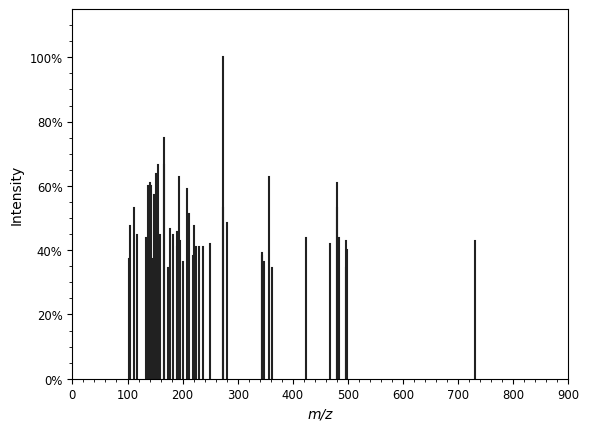

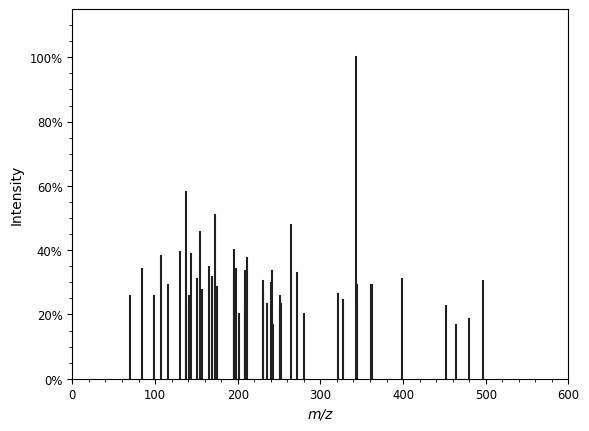

In [17]:
from falcon_ext.cluster import cosine
import spectrum_utils

print(cosine.modified_cosine(spec1, spec2, 0.05))

spectrum_utils.plot.spectrum(spec1, grid=False)
plt.show()
spectrum_utils.plot.spectrum(spec2, grid=False)
plt.show()

In [20]:
with h5py.File(clustered_spectra_file, 'r') as hdf_file:
    print(len(hdf_file.keys()))

41640


In [19]:
masses.sort()

In [21]:
def group_with_tolerance(test_list, tol):
    groups = []
    last = None
    group = []
    for ele in test_list:
        if last is None:
            last = ele
            group.append(ele)
        elif ele - last <= tol:
            group.append(ele)
        else:
            groups.append(group)
            group = [ele]
        last = ele
    groups.append(group)
    return groups

In [30]:
groups = group_with_tolerance(masses, 0.05)
group_sizes = [len(g) for g in groups]
print('number of groups: ' + str(len(groups)))
print('maximum group size: ' + str(max(group_sizes)))

number of groups: 3976
maximum group size: 2493


In [37]:
unique, counts = np.unique(np.array(group_sizes), return_counts=True)

In [ ]:
def _read_spectra_queue(file_queue: queue.Queue, spectra_queue: queue.Queue) -> None:
    """
    Get the spectra from the file queue and store them in the spectra queue.

    Parameters
    ----------
    file_queue : queue.Queue
        Queue from which the file names are retrieved.
    spectra_queue : queue.Queue
        Queue in which spectra are stored.
    """
    while True:
        filename = file_queue.get()
        if filename is None:
            return
        for spec in _read_spectra(filename, config.mz_interval,
                                  config.work_dir):
            spectra_queue.put(spec)


def _read_spectra(filename: str, mz_interval: int, work_dir: str) -> Iterator[Tuple[MsmsSpectrum, str]]:
    """
    Get the spectra from the given file.

    Parameters
    ----------
    filename : str
        The path of the peak file to be read.
    mz_interval : int
        The width of each m/z interval.
    work_dir : str
        The directory in which the spectrum buckets will be stored.

    Returns
    -------
    Iterator[Tuple[MsmsSpectrum, str]]
        The spectra read from the given file and their bucket filenames
        (based on precursor charge and m/z).
    """
    filename = os.path.abspath(filename)
    for spec in ms_io.get_spectra(filename):
        spec.filename = filename
        # bin = _precursor_to_interval(
        #     spec.precursor_mz, spec.precursor_charge, mz_interval)
        # pkl_filename = os.path.join(
        #     work_dir, 'spectra', f'{spec.precursor_charge}_{interval}.pkl')
        yield spec # , pkl_filename

def _precursor_to_bin(spec: MsmsSpectrum, precursor_mz_tol: float):
    bins = [] # list of (min_mz, max_mz, bin_idx, [spectra], [files])
    idx_count = 0
    if len(bins) < 1:
        bins.append((spec.precursor_mz - precursor_mz_tol, spec.precursor_mz + precursor_mz_tol, \
                      idx_count, [spec]))
        idx_count += 1
    else:
        try: 
            bin_idx = [idx for idx, bin in enumerate(bins) if bin[0] <= spec.precursor_mz < bin[1]][0]
            bins[bin_idx] = _update_bin(bins[bin_idx])
            bins = _merge_bins(bins, bin_idx)
            if len(bin[bin_idx] >= 1000):
                # write to file
                bin_filename = f'spectrum_bin_{bin_idx}.pkl'
        except IndexError: # create new bin
            bins.append((spec.precursor_mz - precursor_mz_tol, spec.precursor_mz + precursor_mz_tol, \
                      idx_count, [spec]))
            idx_count += 1            
    

def _update_bin(bin: Tuple[float, float, int, List[MsmsSpectrum]]) -> Tuple[float, float, int, List[MsmsSpectrum]]:
    if spec.precursor_mz - precursor_mz_tol < bin[0]:
        bin[0] = spec.precursor_mz - precursor_mz_tol
    elif spec.precursor_mz + precursor_mz_tol > bin[1]:
        bin[1] = spec.precursor_mz + precursor_mz_tol
    bin[3].append(spec)
    return bin


def _merge_bins(bins, updated_bin):
    for i in range(updated_bin) + range(updated_bin + 1, len(bins)):
        if (bins[i][1] > bins[updated_bin][1] >= bins[i][0]) or (bins[i][0] <= bins[updated_bin][0] < bins[i][1]):
            bins[updated_bin] = _merge(bins[updated_bin], bins[i])
            del bins[i]
            break
    return bins   


def _merge(bin1, bin2):
    new_min = min(bin1[0], bin2[0])
    new_max = max(bin1[1], bin2[1])
    new_bin_idx = min(bin1[2], bin2[2])
    new_spectra_list = bin1[3] + bin2[3]
    return (new_min, new_max, new_bin_idx, new_spectra_list)
    

def _merge_files(bin_idx1, bin_idx2): # determine bin index
    filename1 = f'spectrum_bin_{bin_idx1}.pkl' # add spectra to this file
    filename2 = f'spectrum_bin_{bin_idx2}.pkl' # read spectra from this file
    with open(filename2, 'rb') as read_from:
        spectra = pickle.load(read_from)
        with open(filename1, 'ab+') as write_to: 
            pickle.dump(spectra, write_to)

In [63]:
max_file_workers = min(len(input_files), multiprocessing.cpu_count())
file_queue = queue.Queue()
max_spectra_in_memory = 1_000_000
spectra_queue = queue.Queue(maxsize=max_spectra_in_memory)

for filename in itertools.chain(input_files, itertools.repeat(None, max_file_workers)):
        file_queue.put(filename)

peak_readers = multiprocessing.pool.ThreadPool(max_file_workers, _read_spectra_queue, (file_queue, spectra_queue))

AttributeError: module 'multiprocessing' has no attribute 'pool'